In [38]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
import numpy
from galpy.util import bovy_plot
%pylab inline
from matplotlib import cm
numpy.random.seed(4)
import copy
import matplotlib.animation as animation
from IPython.display import HTML
import seaborn as sns

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# Harmonic-oscillator M2M

## Mock observations

We sample from a distribution $f(z,v_z) \propto e^{-E/\sigma^2}$ with $\sigma = 0.1$. The gravitational potential is $\Phi(z) = \omega^2 z^2 / 2$, with $\omega = 1.3$. Sampling from $f(z,v_z)$ can be simply done by sampling $E \leftarrow e^{-E/\sigma^2}$ and $\phi \leftarrow \mathrm{Uniform(0,2\pi)}$ and then computing $z = \sqrt{2E}/\omega\,\cos\phi,\ v_z = -\sqrt{2E}\, \sin(\phi)$.

In [2]:
n_mock= 10000
sigma_true= 0.1
omega_true= 1.3
E_mock= numpy.random.exponential(scale=sigma_true**2.,size=n_mock)
phi_mock= numpy.random.uniform(size=n_mock)*2.*numpy.pi
z_mock= numpy.sqrt(2.*E_mock)/omega_true*numpy.cos(phi_mock)
vz_mock= -numpy.sqrt(2.*E_mock)*numpy.sin(phi_mock)

The density distribution is Gaussian as expected:

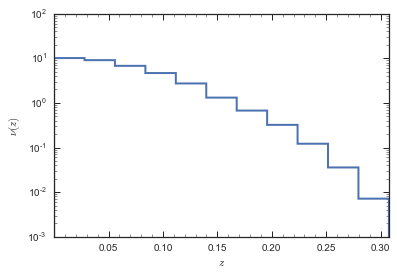

In [3]:
_= bovy_plot.bovy_hist(numpy.fabs(z_mock),bins=11,normed=True,
                       xlabel=r'$z$',ylabel=r'$\nu(z)$',lw=2.,histtype='step')
gca().set_yscale('log')

Now we 'observe' this density distribution from $z_{\mathrm{sun}} = 0.05$:

In [4]:
zsun_true= 0.05
def sph_kernel(r,h):
    out= numpy.zeros_like(r)
    out[(r >= 0.)*(r <= h/2.)]= 1.-6.*(r[(r >= 0.)*(r <= h/2.)]/h)**2.+6.*(r[(r >= 0.)*(r <= h/2.)]/h)**3.
    out[(r > h/2.)*(r <= h)]= 2.*(1-(r[(r > h/2.)*(r <= h)]/h))**3.
    out*= 4./3./h
    return out
def sph_kernel_deriv(r,h):
    out= numpy.zeros_like(r)
    out[(r >= 0.)*(r <= h/2.)]= -12.*r[(r >= 0.)*(r <= h/2.)]/h**2.+18.*r[(r >= 0.)*(r <= h/2.)]**2./h**3.
    out[(r > h/2.)*(r <= h)]= -6./h*(1-(r[(r > h/2.)*(r <= h)]/h))**2.
    out*= 4./3./h
    return out
def epanechnikov_kernel(r,h):
    out= numpy.zeros_like(r)
    out[(r >= 0.)*(r <= h)]= 3./4.*(1.-r[(r >= 0.)*(r <= h)]**2./h**2.)/h
    return out
def epanechnikov_kernel_deriv(r,h):
    out= numpy.zeros_like(r)
    out[(r >= 0.)*(r <= h)]= -3./2.*r[(r >= 0.)*(r <= h)]/h**3.
    return out
if True:
    kernel= epanechnikov_kernel
    kernel_deriv= epanechnikov_kernel_deriv
else:
    kernel= sph_kernel
    kernel_deriv= sph_kernel_deriv
# We only observe the density at a few z
z_obs= numpy.array([0.1,0.15,0.2,-0.1,-0.15,-0.2])
h_obs= 0.025
def compute_dens(z,zsun,z_obs,w=None):
    if w is None: w= numpy.ones_like(z)
    dens= numpy.zeros_like(z_obs)
    for jj,zo in enumerate(z_obs):
        dens[jj]= numpy.sum(w*kernel(numpy.fabs(zo-z+zsun),h_obs))/len(z)
    return dens
dens_obs= compute_dens(z_mock,zsun_true,z_obs)
dens_obs_noise= numpy.sqrt(dens_obs)*0.2*numpy.sqrt(numpy.amax(dens_obs))\
    /(numpy.fabs(z_obs**2)/numpy.amin(numpy.fabs(z_obs**2)))
dens_obs+= numpy.random.normal(size=dens_obs.shape)*dens_obs_noise

The observed density is:

<Container object of 3 artists>

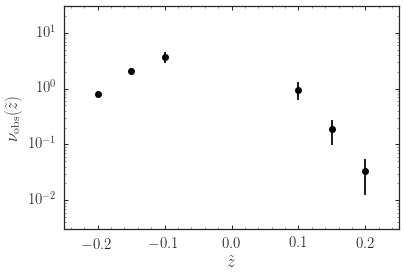

In [5]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_obs,dens_obs,'ko',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.])
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color='k')

## Basic M2M fit

Here we perform the basic M2M fit to the observed density assuming we know the potential.

In [6]:
def force_of_change_weights(w_m2m,zsun_m2m,z_m2m,vz_m2m,
                            eps,mu,w_prior,
                            z_obs,dens_obs,dens_obs_noise,
                            h_m2m=0.02,
                            delta_m2m=None):
    """Computes the force of change for all of the weights"""
    delta_m2m_new= numpy.zeros_like(z_obs)
    Wij= numpy.zeros((len(z_obs),len(z_m2m)))
    for jj,zo in enumerate(z_obs):
        Wij[jj]= kernel(numpy.fabs(zo-z_m2m+zsun_m2m),h_m2m)
        delta_m2m_new[jj]= (numpy.sum(w_m2m*Wij[jj])/len(z_m2m)-dens_obs[jj])/dens_obs_noise[jj]
    if delta_m2m is None: delta_m2m= delta_m2m_new
    return (-eps*w_m2m*(numpy.sum(numpy.tile(delta_m2m/dens_obs_noise,(len(z_m2m),1)).T*Wij,axis=0)\
                        +mu*(numpy.log(w_m2m/w_prior)+1.)),delta_m2m_new)
def run_m2m_weights(w_init,A_init,phi_init,
                    omega_m2m,zsun_m2m,
                    z_obs,dens_obs,dens_obs_noise,
                    step=0.001,nstep=1000,
                    eps=0.1,mu=1.,
                    h_m2m=0.02,
                    smooth=None,
                    output_wevolution=False):
    """
    NAME:
       run_m2m_weights
    PURPOSE:
       Run M2M on the harmonic-oscillator data to optimize just the weights of the orbits
    INPUT:
       w_init - initial weights [N]
       A_init - initial zmax [N]
       phi_init - initial angle (rad) [N]
       omega_m2m - potential parameter omega
       zsun_m2m - Sun's height above the plane [N]
       z_obs - heights at which the density observations are made
       dens_obs - observed densities
       dens_obs_noise - noise in the observed densities
       step= stepsize of orbit integration
       nstep= number of steps to integrate the orbits for
       eps= M2M epsilon parameter
       mu= M2M entropy parameter mu
       h_m2m= kernel size parameter for computing the observables
       smooth= smoothing parameter alpha (None for no smoothing)
       output_wevolution= if set to an integer, return the time evolution of this many randomly selected weights
    OUTPUT:
       (w_out,Q_out,[wevol,rndindx]) - (output weights [N],objective function as a function of time,
                                       [weight evolution for randomly selected weights,index of random weights])
    HISTORY:
       2016-12-06 - Written - Bovy (UofT/CCA)
       2016-12-08 - Added output_wevolution - Bovy (UofT/CCA)
       2016-12-16 - Added explicit noise in the observed densities - Bovy (UofT/CCA)
    """
    w_out= copy.deepcopy(w_init)
    Q_out= []
    if output_wevolution:
        rndindx= numpy.random.permutation(len(w_out))[:output_wevolution]
        wevol= numpy.zeros((output_wevolution,nstep))
    if not smooth is None:
        # Smooth the constraints
        phi_now= phi_init
        z_m2m= A_init*numpy.cos(phi_now)
        vz_m2m= -A_init*omega_m2m*numpy.sin(phi_now) # unnecessary
        dens_init= compute_dens(z_m2m,zsun_m2m,z_obs,w=w_init)
        delta_m2m= (dens_init-dens_obs)/dens_obs_noise
    else:
        delta_m2m= None
    for ii in range(nstep):
        # Compute current (z,vz)
        phi_now= omega_m2m*ii*step+phi_init
        z_m2m= A_init*numpy.cos(phi_now)
        vz_m2m= -A_init*omega_m2m*numpy.sin(phi_now) # unnecessary
        fcw, delta_m2m_new= force_of_change_weights(w_out,zsun_m2m,
                                                    z_m2m,vz_m2m,
                                                    eps,mu,w_init,
                                                    z_obs,
                                                    dens_obs,dens_obs_noise,
                                                    h_m2m=h_m2m,
                                                    delta_m2m=delta_m2m)
        w_out+= step*fcw
        w_out/= numpy.sum(w_out)/len(A_init)
        w_out[w_out < 0.]= 10.**-16.
        if not smooth is None:
            Q_out.append(delta_m2m**2.)
        else:
            Q_out.append(delta_m2m_new**2.)
        # Increment smoothing
        if not smooth is None:
            delta_m2m+= step*smooth*(delta_m2m_new-delta_m2m)
        # Record random weights if requested
        if output_wevolution:
            wevol[:,ii]= w_out[rndindx]
    out= (w_out,numpy.array(Q_out))
    if output_wevolution:
        out= out+(wevol,rndindx,)
    return out

The initial density profile (blue line) is very different from the target:

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))



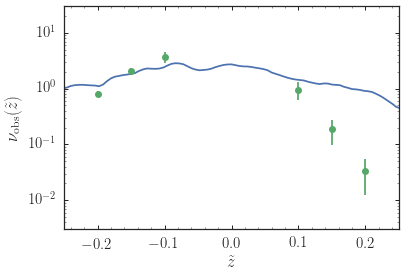

In [7]:
n_m2m= 1000
sigma_init= 0.2
E_m2m= numpy.random.exponential(scale=sigma_init**2.,size=n_m2m)
phi_m2m= numpy.random.uniform(size=n_m2m)*2.*numpy.pi
A_m2m= numpy.sqrt(2.*E_m2m)/omega_true
w_init= numpy.ones(n_m2m)
z_m2m= A_m2m*numpy.cos(phi_m2m)
z_out= numpy.linspace(-0.3,0.3,101)
dens_init= compute_dens(z_m2m,zsun_true,z_out,w_init)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(6,4)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.])
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')

Run without any smoothing:

In [8]:
step= numpy.pi/3.*10.**-2.
nstep= 30000
eps= 10.**-2.
mu= 10.
h_m2m= 0.025
omega_m2m= omega_true
zsun_m2m= zsun_true
w_out,Q,wevol,windx= run_m2m_weights(w_init,A_m2m,phi_m2m,omega_m2m,zsun_m2m,
                                     z_obs,dens_obs,dens_obs_noise,
                                     nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,
                                     output_wevolution=10)

('Velocity dispersions: mock, fit', 0.099971170801918099, 0.1213736208007937)


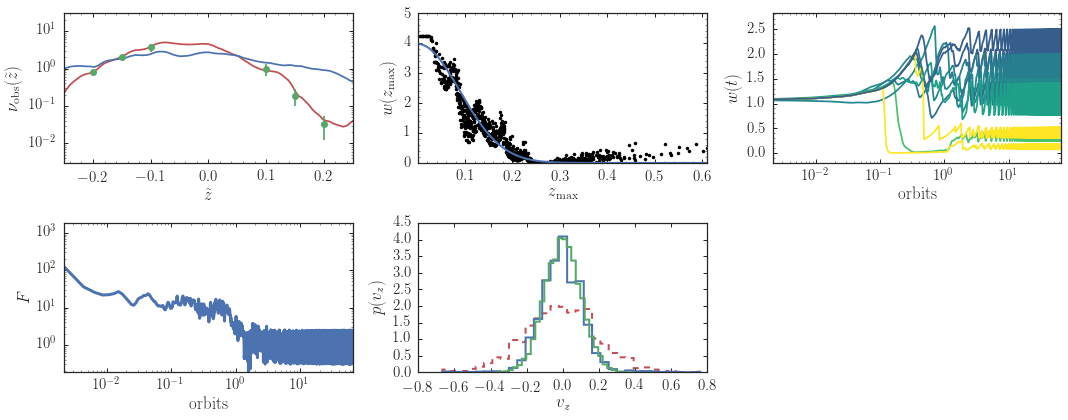

In [9]:
z_m2m= A_m2m*numpy.cos(phi_m2m+nstep*step*omega_m2m)
vz_m2m= -A_m2m*omega_m2m*numpy.sin(phi_m2m+nstep*step*omega_m2m)
z_out= numpy.linspace(-0.3,0.3,101)
dens_final= compute_dens(z_m2m,zsun_true,z_out,w_out)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(2,3,2)
bovy_plot.bovy_plot(A_m2m,w_out,'k.',xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                   yrange=[0.,5.],gcf=True)
sindx= numpy.argsort(A_m2m)
w_expect= numpy.exp((A_m2m[sindx]*omega_m2m)**2./2.*(1./sigma_init**2.-1./sigma_true**2.))
w_expect/= numpy.sum(w_expect)/len(w_expect)
plot(A_m2m[sindx],w_expect,lw=2.)
subplot(2,3,3)
for ii in range(len(wevol)):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,wevol[ii],'-',
                        color=cm.viridis(A_m2m[windx][ii]/0.3),
                        yrange=[-0.2,numpy.amax(wevol)*1.1],
                        semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
subplot(2,3,4)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$F$',gcf=True)
subplot(2,3,5)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,zorder=2)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,ls='--',zorder=0)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
tight_layout()

We can also look at how the density converges (this is a movie):

In [10]:
step= numpy.pi/3.*10.**-2.
nstep= 10000
eps= 10.**-2.
mu= 10.
h_m2m= 0.025
omega_m2m= omega_true
zsun_m2m= zsun_true
w_out,Q,wevol,windx= run_m2m_weights(w_init,A_m2m,phi_m2m,omega_m2m,zsun_m2m,
                                     z_obs,dens_obs,dens_obs_noise,
                                     nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,
                                     output_wevolution=len(w_init))

In [11]:
def init_anim_frame():
    line1= bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,color=sns.color_palette()[0],
                       xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                       xrange=[-.25,0.25],yrange=[0.003,30.],gcf=True)
    line2= bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True,color=sns.color_palette()[1])
    line3= errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
    return (line1[0],line2[0],line3[0])
figsize(6,4)
fig, ax = subplots()
line, = ax.plot([],[],lw=2)
subsamp= 30
def animate(ii):
    z_m2m= A_m2m*numpy.cos(phi_m2m+ii*subsamp*step*omega_m2m)
    vz_m2m= -A_m2m*omega_m2m*numpy.sin(phi_m2m+ii*subsamp*step*omega_m2m)
    dens_final= compute_dens(z_m2m[windx],zsun_true,z_out,wevol[:,ii*subsamp])
    line.set_data(z_out,dens_final)
    line.set_color(color=sns.color_palette()[2])
    return (line,)
anim = animation.FuncAnimation(fig,animate,init_func=init_anim_frame,
                               frames=nstep/subsamp,interval=40,blit=True,repeat=False)
# The following is necessary to just get the movie, and not an additional initial frame
plt.close()
out= HTML(anim.to_html5_video())
plt.close()
out

Run with smoothing:

In [12]:
step= numpy.pi/3.*10.**-2.
nstep= 30000
eps= 10.**-2.
mu= 10.
h_m2m= 0.025
smooth= 10.*10.**-1.
omega_m2m= omega_true
zsun_m2m= zsun_true
w_out,Q,wevol,windx= run_m2m_weights(w_init,A_m2m,phi_m2m,omega_m2m,zsun_m2m,
                                     z_obs,dens_obs,dens_obs_noise,
                                     nstep=nstep,step=step,mu=mu,eps=eps,smooth=smooth,h_m2m=h_m2m,
                                     output_wevolution=10)

('Velocity dispersions: mock, fit', 0.099971170801918099, 0.12712285418137104)


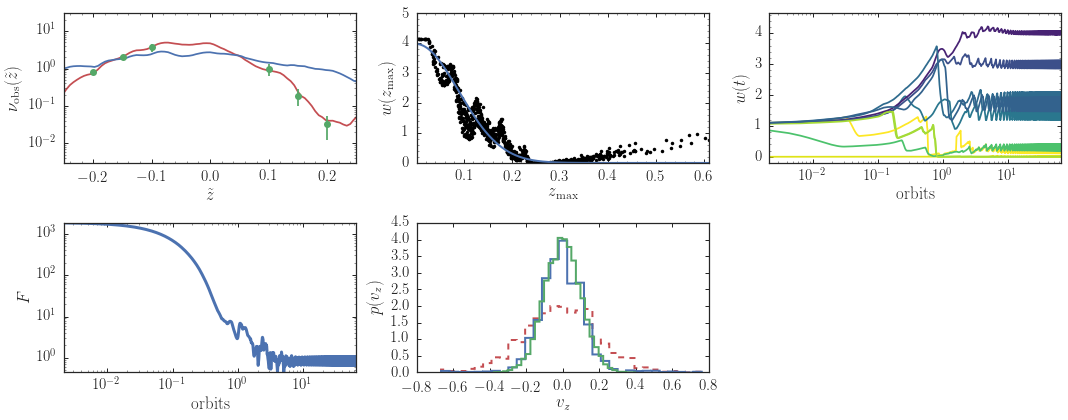

In [13]:
z_m2m= A_m2m*numpy.cos(phi_m2m+nstep*step*omega_m2m)
vz_m2m= -A_m2m*omega_m2m*numpy.sin(phi_m2m+nstep*step*omega_m2m)
z_out= numpy.linspace(-0.3,0.3,101)
dens_final= compute_dens(z_m2m,zsun_true,z_out,w_out)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(2,3,2)
bovy_plot.bovy_plot(A_m2m,w_out,'k.',xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                   yrange=[0.,5.],gcf=True)
sindx= numpy.argsort(A_m2m)
w_expect= numpy.exp((A_m2m[sindx]*omega_m2m)**2./2.*(1./sigma_init**2.-1./sigma_true**2.))
w_expect/= numpy.sum(w_expect)/len(w_expect)
plot(A_m2m[sindx],w_expect,lw=2.)
subplot(2,3,3)
for ii in range(len(wevol)):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,wevol[ii],'-',
                        color=cm.viridis(A_m2m[windx][ii]/0.3),
                        yrange=[-0.2,numpy.amax(wevol)*1.1],
                        semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
subplot(2,3,4)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$F$',gcf=True)
subplot(2,3,5)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,zorder=2)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,ls='--',zorder=0)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
tight_layout()

## Also vary $z_\odot$ during the optimization

We write down the force of change for $z_\odot$ and also fit for it:

In [14]:
def force_of_change_zsun(w_m2m,zsun_m2m,z_m2m,vz_m2m,
                         eps,mu,w_prior,
                         z_obs,dens_obs,dens_obs_noise,
                         h_m2m=0.02,
                         delta_m2m=None):
    """Computes the force of change for zsun"""
    out= 0.
    for jj,zo in enumerate(z_obs):
        dWij= kernel_deriv(numpy.fabs(zo-z_m2m+zsun_m2m),h_m2m)*numpy.sign(zo-z_m2m+zsun_m2m)
        out+= delta_m2m[jj]/dens_obs_noise[jj]*numpy.sum(w_m2m*dWij)/len(z_m2m)
    return -eps*out
def run_m2m_weights_zsun(w_init,A_init,phi_init,
                        omega_m2m,zsun_m2m,
                        z_obs,dens_obs,dens_obs_noise,
                        step=0.001,nstep=1000,
                        eps=0.1,eps_zo=0.001,mu=1.,
                        h_m2m=0.02,
                        smooth=None,
                        output_wevolution=False):
    """
    NAME:
       run_m2m_weights_zsun
    PURPOSE:
       Run M2M on the harmonic-oscillator data to optimize the weights of the orbits as well as the Sun's height
    INPUT:
       w_init - initial weights [N]
       A_init - initial zmax [N]
       phi_init - initial angle (rad) [N]
       omega_m2m - potential parameter omega
       zsun_m2m - Sun's height above the plane [N]
       z_obs - heights at which the density observations are made
       dens_obs - observed densities
       dens_obs_noise - noise in the observed densities
       step= stepsize of orbit integration
       nstep= number of steps to integrate the orbits for
       eps= M2M epsilon parameter
       eps_zo= M2M epsilon parameter for zsun force of change
       mu= M2M entropy parameter mu
       h_m2m= kernel size parameter for computing the observables
       smooth= smoothing parameter alpha (None for no smoothing)
       output_wevolution= if set to an integer, return the time evolution of this many randomly selected weights
    OUTPUT:
       ((w_out,zsun_out),Q_out,[wevol,rndindx]) - ((output weights [N],output zsun [nstep]),
                                                    objective function as a function of time,
                                                   [weight evolution for randomly selected weights,
                                                   index of random weights])
    HISTORY:
       2016-12-06 - Written - Bovy (UofT/CCA)
       2016-12-09 - Added output_wevolution - Bovy (UofT/CCA)
       2016-12-16 - Added explicit noise in the observed densities - Bovy (UofT/CCA)
    """
    w_out= copy.deepcopy(w_init)
    zsun_out= []
    Q_out= []
    if output_wevolution:
        rndindx= numpy.random.permutation(len(w_out))[:output_wevolution]
        wevol= numpy.zeros((output_wevolution,nstep))
    if not smooth is None:
        # Smooth the constraints
        phi_now= phi_init
        z_m2m= A_init*numpy.cos(phi_now)
        vz_m2m= -A_init*omega_m2m*numpy.sin(phi_now) # unnecessary
        dens_init= compute_dens(z_m2m,zsun_m2m,z_obs,w=w_init)
        delta_m2m= (dens_init-dens_obs)/dens_obs_noise
    else:
        delta_m2m= None
    for ii in range(nstep):
        # Compute current (z,vz)
        phi_now= omega_m2m*ii*step+phi_init
        z_m2m= A_init*numpy.cos(phi_now)
        vz_m2m= -A_init*omega_m2m*numpy.sin(phi_now) # unnecessary
        fcw, delta_m2m_new= force_of_change_weights(w_out,zsun_m2m,
                                                    z_m2m,vz_m2m,
                                                    eps,mu,w_init,
                                                    z_obs,dens_obs,dens_obs_noise,
                                                    h_m2m=h_m2m,
                                                    delta_m2m=delta_m2m)
        if smooth is None:
            fcz= force_of_change_zsun(w_out,zsun_m2m,
                                      z_m2m,vz_m2m,
                                      eps_zo,mu,w_init,
                                      z_obs,dens_obs,dens_obs_noise,
                                      h_m2m=h_m2m,delta_m2m=delta_m2m_new)
        else:
            fcz= force_of_change_zsun(w_out,zsun_m2m,
                                      z_m2m,vz_m2m,
                                      eps_zo,mu,w_init,
                                      z_obs,dens_obs,dens_obs_noise,
                                      h_m2m=h_m2m,delta_m2m=delta_m2m)
        #print(fcz)
        w_out+= step*fcw
        w_out/= numpy.sum(w_out)/len(A_init)
        w_out[w_out < 0.]= 10.**-16.
        zsun_m2m+= step*fcz
        zsun_out.append(zsun_m2m)
        Q_out.append(delta_m2m_new**2.)
        # Increment smoothing
        if not smooth is None:
            delta_m2m= step*smooth*(delta_m2m_new-delta_m2m)
        if output_wevolution:
            wevol[:,ii]= w_out[rndindx]
    out= ((w_out,numpy.array(zsun_out)),numpy.array(Q_out))
    if output_wevolution:
        out= out+(wevol,rndindx,)
    return out

In [15]:
step= numpy.pi/3.*10.**-2.
nstep= 100000
eps= 10.**-2.
eps_zo= eps/500.
mu= 10.
h_m2m= 0.025
omega_m2m= omega_true
zsun_m2m= zsun_true-0.05
(w_out,zsun_out),Q,wevol,windx= run_m2m_weights_zsun(w_init,A_m2m,phi_m2m,omega_m2m,zsun_m2m,
                                                     z_obs,dens_obs,dens_obs_noise,
                                                     nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,
                                                     eps_zo=eps_zo,output_wevolution=10)

('Velocity dispersions: mock, fit', 0.099971170801918099, 0.11888648784992253)
('Zsun: fit, starting point', 0.04477544694014865, 0.0)


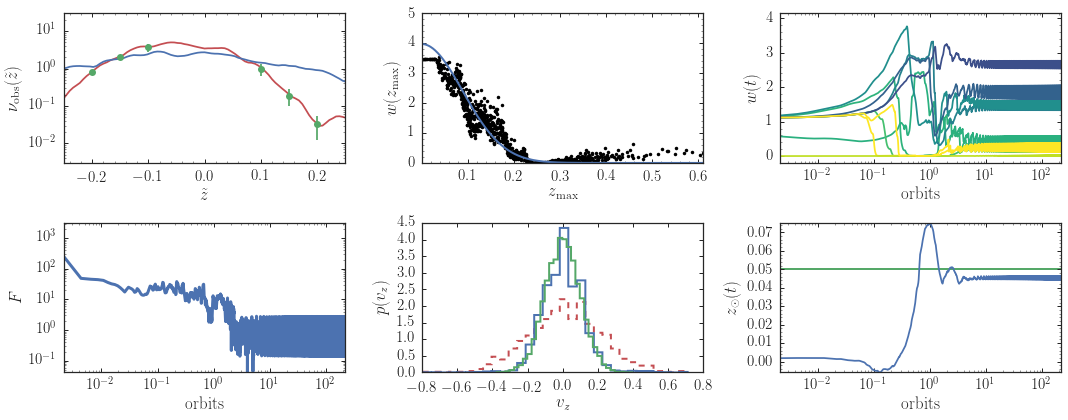

In [16]:
z_m2m= A_m2m*numpy.cos(phi_m2m+nstep*step*omega_m2m)
vz_m2m= -A_m2m*omega_m2m*numpy.sin(phi_m2m+nstep*step*omega_m2m)
z_out= numpy.linspace(-0.3,0.3,101)
dens_final= compute_dens(z_m2m,zsun_out[-1],z_out,w_out)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(2,3,2)
bovy_plot.bovy_plot(A_m2m,w_out,'k.',xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                   yrange=[0.,5.],gcf=True)
sindx= numpy.argsort(A_m2m)
w_expect= numpy.exp((A_m2m[sindx]*omega_m2m)**2./2.*(1./sigma_init**2.-1./sigma_true**2.))
w_expect/= numpy.sum(w_expect)/len(w_expect)
plot(A_m2m[sindx],w_expect,lw=2.)
subplot(2,3,3)
for ii in range(len(wevol)):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,wevol[ii],'-',
                        color=cm.viridis(A_m2m[windx][ii]/0.3),
                        yrange=[-0.2,numpy.amax(wevol)*1.1],
                        semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
subplot(2,3,4)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_m2m/2./numpy.pi,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$F$',gcf=True)
subplot(2,3,5)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,zorder=2)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,ls='--',zorder=0)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
subplot(2,3,6)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_m2m/2./numpy.pi,zsun_out,'-',
                   xlabel=r'$\mathrm{orbits}$',ylabel=r'$z_\odot(t)$',gcf=True,semilogx=True,zorder=1)
axhline(zsun_true,color=sns.color_palette()[1],lw=2.,zorder=0)
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
tight_layout()
print("Zsun: fit, starting point",zsun_out[-1],zsun_m2m)

Let's compare this to doing the basic M2M fit for different values of $z_\odot$

In [17]:
zsuns= numpy.linspace(0.0,0.1,11)
step= numpy.pi/3.*10.**-2.
nstep= 30000
eps= 10.**-2.
mu= 10.
h_m2m= 0.025
omega_m2m= omega_true
Qs= numpy.zeros_like(zsuns)
for ii,zsun_m2m in enumerate(zsuns):
    w_out,Q= run_m2m_weights(w_init,A_m2m,phi_m2m,omega_m2m,zsun_m2m,
                             z_obs,dens_obs,dens_obs_noise,nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m)
    Qs[ii]= numpy.sum(numpy.median(Q[-100:-1],axis=0))

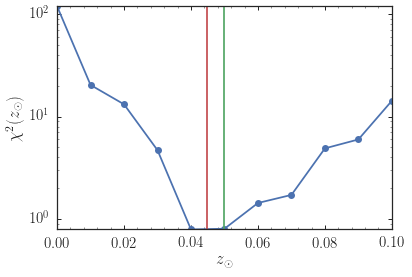

In [18]:
figsize(6,4)
bovy_plot.bovy_plot(zsuns,Qs,'o-',semilogy=True,
                   xlabel=r'$z_\odot$',ylabel=r'$\chi^2(z_\odot)$')
axvline(zsun_true,color=sns.color_palette()[1])
axvline(zsun_out[-1],color=sns.color_palette()[2])

What's the answer when we fit a simple isothermal DF?

In [19]:
def lnL_df(p,z_obs,dens_obs,dens_obs_noise):
    """p=[zsun,sigma]"""
    return -0.5*numpy.sum((numpy.exp(-0.5*(z_obs+p[0])**2.*omega_true**2./p[1]**2.)*omega_true/p[1]/numpy.sqrt(2.*numpy.pi)
                                       -dens_obs)**2./dens_obs_noise**2.)
sigmas= numpy.linspace(0.05,0.12,201)
zsuns= numpy.linspace(0.0,0.1,201)
lnL= numpy.zeros((len(zsuns),len(sigmas)))
for ii,zsun in enumerate(zsuns):
    for jj,sigma in enumerate(sigmas):
        lnL[ii,jj]= lnL_df([zsun,sigma],z_obs,dens_obs,dens_obs_noise)

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_base.py:1210: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_base.py:1215: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):

Best fit: (zsun,sigma) = (0.048,0.102)


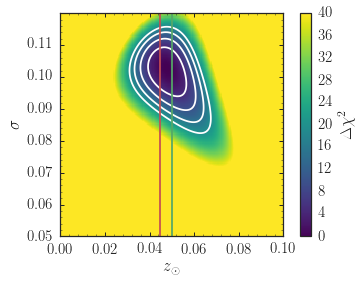

In [20]:
bovy_plot.bovy_dens2d(-2.*(lnL-numpy.amax(lnL)).T,origin='lower',
                      xrange=[zsuns[0],zsuns[-1]],
                      yrange=[sigmas[0],sigmas[-1]],
                      xlabel=r'$z_\odot$',ylabel=r'$\sigma$',
                      zlabel=r'$\Delta\chi^2$',
                      colorbar=True,cmap='viridis',vmax=40.,
                      contours=True,levels=numpy.arange(5)*5.,cntrcolors='w',
                      interpolation='nearest')
axvline(zsun_true,color=sns.color_palette()[1])
axvline(zsun_out[-1],color=sns.color_palette()[2])
print("Best fit: (zsun,sigma) = (%.3f,%.3f)"\
          %(zsuns[numpy.unravel_index(numpy.argmax(lnL),(len(zsuns),len(sigmas)))[0]],
            sigmas[numpy.unravel_index(numpy.argmax(lnL),(len(zsuns),len(sigmas)))[1]]))

Thus, the M2M optimization finds the correct value.

## Also fit some velocity data

To prepare for trying to recover the gravitational potential at the same time as the weights, we add velocity information and fit this as well in the forces of change. The velocity data that we fit is the density $\times$ the mean squared velocity; we generate these data from the mock data set above:

In [21]:
# We only observe the densityxv2 at a few z (same as before)
def compute_densv2(z,vz,zsun,z_obs,w=None):
    if w is None: w= numpy.ones_like(z)
    densv2= numpy.zeros_like(z_obs)
    for jj,zo in enumerate(z_obs):
        densv2[jj]= numpy.sum(w*kernel(numpy.fabs(zo-z+zsun),h_obs)*vz**2.)/len(z)
    return densv2
densv2_obs= compute_densv2(z_mock,vz_mock,zsun_true,z_obs)
densv2_obs_noise= numpy.sqrt(densv2_obs)*0.2*numpy.sqrt(numpy.amax(densv2_obs))\
    /(numpy.fabs(z_obs**2)/numpy.amin(numpy.fabs(z_obs**2)))
densv2_obs+= numpy.random.normal(size=densv2_obs.shape)*densv2_obs_noise

z_m2m= A_m2m*numpy.cos(phi_m2m)
vz_m2m= -omega_true*A_m2m*numpy.sin(phi_m2m)
densv2_init= compute_densv2(z_m2m,vz_m2m,zsun_true,z_out,w_init)

The observables are now:

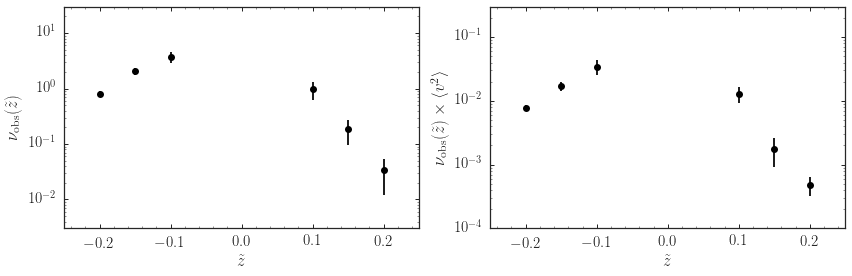

In [22]:
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(z_obs,dens_obs,'ko',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.],gcf=True)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color='k')
subplot(1,2,2)
bovy_plot.bovy_plot(z_obs,densv2_obs,'ko',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})\times \langle v^2\rangle$',
                   xrange=[-.25,0.25],yrange=[0.0001,.3],gcf=True)
errorbar(z_obs,densv2_obs,yerr=densv2_obs_noise,marker='None',ls='none',color='k')
tight_layout()

These make sense, because the velocity dispersion is constant so $\nu\times\langle v^2\rangle$ is just a rescaling of $\nu$. Let's include these observables in the force of change for the weights.

In [23]:
def force_of_change_weights_v2(w_m2m,zsun_m2m,z_m2m,vz_m2m,
                               eps,mu,w_prior,
                               z_obs,densv2_obs,densv2_obs_noise,
                               h_m2m=h_obs,
                               deltav2_m2m=None):
    """Computes the force of change for all of the weights due to the velocity constraint"""
    deltav2_m2m_new= numpy.zeros_like(z_obs)
    Wij= numpy.zeros((len(z_obs),len(z_m2m)))
    for jj,zo in enumerate(z_obs):
        Wij[jj]= kernel(numpy.fabs(zo-z_m2m+zsun_m2m),h_m2m)
        deltav2_m2m_new[jj]= (numpy.sum(w_m2m*Wij[jj]*vz_m2m**2.)/len(z_m2m)-densv2_obs[jj])/densv2_obs_noise[jj]
    if deltav2_m2m is None: deltav2_m2m= deltav2_m2m_new
    return (-eps*w_m2m*numpy.sum(numpy.tile(deltav2_m2m/densv2_obs_noise,(len(z_m2m),1)).T*Wij,axis=0)*vz_m2m**2.,
            deltav2_m2m_new)
def run_m2m_weights_wv2(w_init,A_init,phi_init,
                        omega_m2m,zsun_m2m,
                        z_obs,
                        dens_obs,dens_obs_noise,
                        densv2_obs,densv2_obs_noise,
                        step=0.001,nstep=1000,
                        eps=0.1,eps_vel=0.1,mu=1.,
                        h_m2m=0.02,
                        smooth=None,nodens=False,
                        output_wevolution=False):
    """
    NAME:
       run_m2m_weights_wv2
    PURPOSE:
       Run M2M on the harmonic-oscillator data to optimize just the weights of the orbits, using both density and
       velocity data
    INPUT:
       w_init - initial weights [N]
       A_init - initial zmax [N]
       phi_init - initial angle (rad) [N]
       omega_m2m - potential parameter omega
       zsun_m2m - Sun's height above the plane [N]
       z_obs - heights at which the density observations are made
       dens_obs - observed densities
       dens_obs_noise - noise in the observed densities
       densv2_obs - observed density x velocity-squareds
       densv2_obs_noise - noise in the observed densities x velocity-squareds
       step= stepsize of orbit integration
       nstep= number of steps to integrate the orbits for
       eps= M2M epsilon parameter
       eps_vel= M2M epsilon parameter for the velocity change
       mu= M2M entropy parameter mu
       h_m2m= kernel size parameter for computing the observables
       smooth= smoothing parameter alpha (None for no smoothing)
       nodens= if True, don't fit the density data (also doesn't include entropy term)
       output_wevolution= if set to an integer, return the time evolution of this many randomly selected weights
    OUTPUT:
       (w_out,Q_out,[wevol,rndindx]) - (output weights [N],objective function as a function of time,
                                       [weight evolution for randomly selected weights,index of random weights])
    HISTORY:
       2016-12-07 - Written - Bovy (UofT/CCA)
       2016-12-09 - Added output_wevolution - Bovy (UofT/CCA)
       2016-12-16 - Added explicit noise in the observed densities and densities x velocity-squared - Bovy (UofT/CCA)
    """
    w_out= copy.deepcopy(w_init)
    Q_out= []
    if output_wevolution:
        rndindx= numpy.random.permutation(len(w_out))[:output_wevolution]
        wevol= numpy.zeros((output_wevolution,nstep))
    if not smooth is None:
        # Smooth the constraints
        phi_now= phi_init
        z_m2m= A_init*numpy.cos(phi_now)
        vz_m2m= -A_init*omega_m2m*numpy.sin(phi_now) # unnecessary
        dens_init= compute_dens(z_m2m,zsun_m2m,z_obs,w=w_init)
        delta_m2m= (dens_init-dens_obs)/dens_obs_noise
        densv2_init= compute_densv2(z_m2m,vz_m2m,zsun_m2m,z_obs,w=w_init)
        deltav2_m2m= (densv2_init-densv2_obs)/densv2_obs_noise
    else:
        delta_m2m= None
        deltav2_m2m= None
    for ii in range(nstep):
        # Compute current (z,vz)
        phi_now= omega_m2m*ii*step+phi_init
        z_m2m= A_init*numpy.cos(phi_now)
        vz_m2m= -A_init*omega_m2m*numpy.sin(phi_now) # unnecessary
        fcw, delta_m2m_new= force_of_change_weights(w_out,zsun_m2m,
                                                    z_m2m,vz_m2m,
                                                    eps,mu,w_init,
                                                    z_obs,dens_obs,dens_obs_noise,
                                                    h_m2m=h_m2m,
                                                    delta_m2m=delta_m2m)
        fcwv2, deltav2_m2m_new= force_of_change_weights_v2(w_out,zsun_m2m,
                                                           z_m2m,vz_m2m,
                                                           eps_vel,mu,w_init,
                                                           z_obs,
                                                           densv2_obs,densv2_obs_noise,
                                                           h_m2m=h_m2m,
                                                           deltav2_m2m=deltav2_m2m)
        w_out+= step*fcw*(1.-nodens)+step*fcwv2
        w_out/= numpy.sum(w_out)/len(A_init)
        w_out[w_out < 0.]= 10.**-16.
        if not smooth is None:
            Q_out.append(delta_m2m**2.*(1.-nodens)+deltav2_m2m**2.)
        else:
            Q_out.append(delta_m2m_new**2.*(1.-nodens)+deltav2_m2m_new**2.)
        # Increment smoothing
        if not smooth is None:
            delta_m2m+= step*smooth*(delta_m2m_new-delta_m2m)
            deltav2_m2m+= step*smooth*(deltav2_m2m_new-deltav2_m2m)
        if output_wevolution:
            wevol[:,ii]= w_out[rndindx]
    out= (w_out,numpy.array(Q_out))
    if output_wevolution:
        out= out+(wevol,rndindx,)
    return out

Run without smoothing, just using the velocity constraint:

In [24]:
step= numpy.pi/3.*10.**-2.
nstep= 30000
eps= 10.**-3.
eps_vel= eps/1.
mu= 10.
h_m2m= 0.025
nodens= True
omega_m2m= omega_true
zsun_m2m= zsun_true
z_out= numpy.linspace(-0.3,0.3,101)
w_out,Q,wevol,windx= run_m2m_weights_wv2(w_init,A_m2m,phi_m2m,omega_m2m,zsun_m2m,
                                         z_obs,dens_obs,dens_obs_noise,densv2_obs,densv2_obs_noise,
                                         nstep=nstep,step=step,mu=mu,eps=eps,h_m2m=h_m2m,nodens=nodens,
                                         output_wevolution=10,eps_vel=eps_vel)

('Velocity dispersions: mock, fit', 0.099971170801918099, 0.093009280864304697)


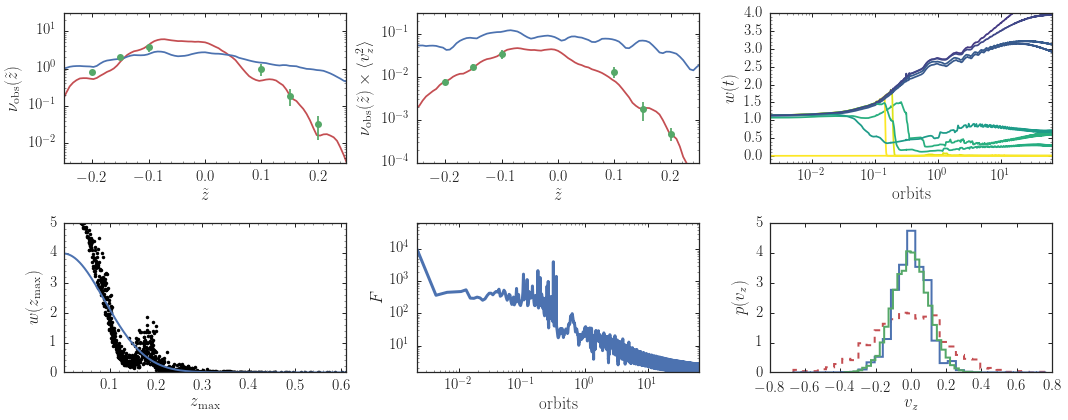

In [25]:
z_m2m= A_m2m*numpy.cos(phi_m2m+nstep*step*omega_m2m)
vz_m2m= -A_m2m*omega_m2m*numpy.sin(phi_m2m+nstep*step*omega_m2m)
z_out= numpy.linspace(-0.3,0.3,101)
dens_final= compute_dens(z_m2m,zsun_true,z_out,w_out)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(2,3,2)
densv2_final= compute_densv2(z_m2m,vz_m2m,zsun_true,z_out,w_out)
bovy_plot.bovy_plot(z_out,densv2_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})\times\langle v_z^2\rangle$',
                   xrange=[-.25,0.25],yrange=[0.0001,.3],gcf=True)
bovy_plot.bovy_plot(z_obs,densv2_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,densv2_final,'-',semilogy=True,overplot=True,zorder=0)
errorbar(z_obs,densv2_obs,yerr=densv2_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(2,3,3)
for ii in range(len(wevol)):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,wevol[ii],'-',
                        color=cm.viridis(A_m2m[windx][ii]/0.3),
                        yrange=[-0.2,numpy.amin([4.,numpy.amax(wevol)*1.1])],
                        semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
subplot(2,3,4)
bovy_plot.bovy_plot(A_m2m,w_out,'k.',xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                   yrange=[0.,5.],gcf=True)
sindx= numpy.argsort(A_m2m)
w_expect= numpy.exp((A_m2m[sindx]*omega_m2m)**2./2.*(1./sigma_init**2.-1./sigma_true**2.))
w_expect/= numpy.sum(w_expect)/len(w_expect)
plot(A_m2m[sindx],w_expect,lw=2.)
subplot(2,3,5)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_m2m/2./numpy.pi,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$F$',gcf=True)
subplot(2,3,6)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,zorder=2)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,ls='--',zorder=0)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
tight_layout()

Let's look at how the density $\times$ velocity squared converges (this is a movie):

In [26]:
step= numpy.pi/3.*10.**-2.
nstep= 10000
eps= 10.**-3.
eps_vel= eps/1.
mu= 10.
h_m2m= 0.025
nodens= True
omega_m2m= omega_true
zsun_m2m= zsun_true
z_out= numpy.linspace(-0.3,0.3,101)
densv2_init= compute_densv2(z_m2m,vz_m2m,zsun_true,z_out,w_init)
w_out,Q,wevol,windx= run_m2m_weights_wv2(w_init,A_m2m,phi_m2m,omega_m2m,zsun_m2m,
                                         z_obs,dens_obs,dens_obs_noise,densv2_obs,densv2_obs_noise,
                                         nstep=nstep,step=step,mu=mu,eps=eps,eps_vel=eps_vel,
                                         h_m2m=h_m2m,nodens=nodens,
                                         output_wevolution=len(w_init))

In [27]:
def init_anim_frame():
    line1= bovy_plot.bovy_plot(z_out,densv2_init,'-',semilogy=True,color=sns.color_palette()[0],
                       xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})\times\langle v_z^2\rangle$',
                       xrange=[-.25,0.25],yrange=[0.0001,.3],gcf=True)
    line2= bovy_plot.bovy_plot(z_obs,densv2_obs,'o',semilogy=True,overplot=True,color=sns.color_palette()[1])
    line3= errorbar(z_obs,densv2_obs,yerr=densv2_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
    return (line1[0],line2[0],line3[0])
figsize(6,4)
fig, ax = subplots()
line, = ax.plot([],[],lw=2)
subsamp= 10
def animate(ii):
    z_m2m= A_m2m*numpy.cos(phi_m2m+ii*subsamp*step*omega_m2m)
    vz_m2m= -A_m2m*omega_m2m*numpy.sin(phi_m2m+ii*subsamp*step*omega_m2m)
    densv2_final= compute_densv2(z_m2m[windx],vz_m2m[windx],zsun_true,z_out,wevol[:,ii*subsamp])
    line.set_data(z_out,densv2_final)
    line.set_color(color=sns.color_palette()[2])
    return (line,)
anim = animation.FuncAnimation(fig,animate,init_func=init_anim_frame,
                               frames=nstep/subsamp,interval=40,blit=True,repeat=False)
# The following is necessary to just get the movie, and not an additional initial frame
plt.close()
out= HTML(anim.to_html5_video())
plt.close()
out

Run without smoothing, both the velocity and density constraint:

In [28]:
step= numpy.pi/3.*10.**-2.
nstep= 30000
eps= 10.**-3.
eps_vel= eps/1.
mu= 10.
h_m2m= 0.025
nodens= False
omega_m2m= omega_true
zsun_m2m= zsun_true
z_out= numpy.linspace(-0.3,0.3,101)
densv2_init= compute_densv2(z_m2m,vz_m2m,zsun_true,z_out,w_init)
w_out,Q,wevol,windx= run_m2m_weights_wv2(w_init,A_m2m,phi_m2m,omega_m2m,zsun_m2m,
                                         z_obs,dens_obs,dens_obs_noise,densv2_obs,densv2_obs_noise,
                                         nstep=nstep,step=step,mu=mu,eps=eps,eps_vel=eps_vel,
                                         h_m2m=h_m2m,nodens=nodens,
                                         output_wevolution=10)

('Velocity dispersions: mock, fit', 0.099971170801918099, 0.097035462001535552)


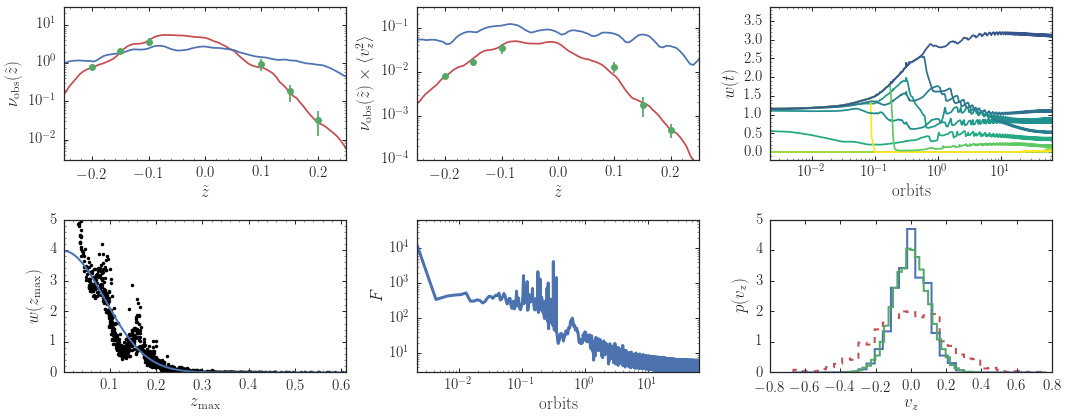

In [29]:
z_m2m= A_m2m*numpy.cos(phi_m2m+nstep*step*omega_m2m)
vz_m2m= -A_m2m*omega_m2m*numpy.sin(phi_m2m+nstep*step*omega_m2m)
z_out= numpy.linspace(-0.3,0.3,101)
dens_final= compute_dens(z_m2m,zsun_true,z_out,w_out)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(2,3,2)
densv2_final= compute_densv2(z_m2m,vz_m2m,zsun_true,z_out,w_out)
bovy_plot.bovy_plot(z_out,densv2_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})\times\langle v_z^2\rangle$',
                   xrange=[-.25,0.25],yrange=[0.0001,.3],gcf=True)
bovy_plot.bovy_plot(z_obs,densv2_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,densv2_final,'-',semilogy=True,overplot=True,zorder=0)
errorbar(z_obs,densv2_obs,yerr=densv2_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(2,3,3)
for ii in range(len(wevol)):
    bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,wevol[ii],'-',
                        color=cm.viridis(A_m2m[windx][ii]/0.3),
                        yrange=[-0.2,numpy.amin([4.,numpy.amax(wevol)*1.1])],
                        semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$w(t)$',gcf=True,overplot=ii>0)
subplot(2,3,4)
bovy_plot.bovy_plot(A_m2m,w_out,'k.',xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                   yrange=[0.,5.],gcf=True)
sindx= numpy.argsort(A_m2m)
w_expect= numpy.exp((A_m2m[sindx]*omega_m2m)**2./2.*(1./sigma_init**2.-1./sigma_true**2.))
w_expect/= numpy.sum(w_expect)/len(w_expect)
plot(A_m2m[sindx],w_expect,lw=2.)
subplot(2,3,5)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_m2m/2./numpy.pi,numpy.sum(Q,axis=1),lw=3.,
                   loglog=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$F$',gcf=True)
subplot(2,3,6)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,zorder=2)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,ls='--',zorder=0)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
tight_layout()

## Also fit for the potential during the optimization

Now we will attempt to simultaneously optimize the potential and the weights using the combined density data. For this, we need to write down the force of change for the potential parameter:

In [30]:
# Functions that return the difference in z and vz for orbits starting at the same (z,vz)_init integrated
# in potentials with different omega
def zdiff(z_init,vz_init,omega1,omega2,t):
    A1= numpy.sqrt(z_init**2.+vz_init**2./omega1**2.)
    A2= numpy.sqrt(z_init**2.+vz_init**2./omega2**2.)
    phi1= numpy.arctan2(-vz_init/omega1,z_init)
    phi2= numpy.arctan2(-vz_init/omega2,z_init)
    return A2*numpy.cos(omega2*t+phi2)-A1*numpy.cos(omega1*t+phi1)
def vzdiff(z_init,vz_init,omega1,omega2,t):
    A1= numpy.sqrt(z_init**2.+vz_init**2./omega1**2.)
    A2= numpy.sqrt(z_init**2.+vz_init**2./omega2**2.)
    phi1= numpy.arctan2(-vz_init/omega1,z_init)
    phi2= numpy.arctan2(-vz_init/omega2,z_init)
    return -A2*omega2*numpy.sin(omega2*t+phi2)+A1*omega1*numpy.sin(omega1*t+phi1)
def force_of_change_omega(w_m2m,zsun_m2m,omega_m2m,
                          z_m2m,vz_m2m,z_prev,vz_prev,
                          step,eps_omega,eps,eps_vel,mu,w_prior,
                          z_obs,dens_obs,dens_obs_noise,densv2_obs,densv2_obs_noise,
                          h_m2m=0.02,delta_omega=0.3,
                          delta_m2m=None,deltav2_m2m=None):
    # Compute the force of change by directly finite difference of the objective function
    # REAL HACK FOLLOWS!
    fcw, delta_m2m_do= force_of_change_weights(w_out,zsun_m2m,
                                               z_m2m+zdiff(z_prev,vz_prev,omega_m2m,omega_m2m+delta_omega,step),
                                               vz_m2m+vzdiff(z_prev,vz_prev,omega_m2m,omega_m2m+delta_omega,step),
                                               eps,mu,w_init,
                                               z_obs,dens_obs,dens_obs_noise,
                                               h_m2m=h_m2m,
                                               delta_m2m=None)
    fcwv2, deltav2_m2m_do= force_of_change_weights_v2(w_out,zsun_m2m,
                                                      z_m2m+zdiff(z_prev,vz_prev,omega_m2m,omega_m2m+delta_omega,step),
                                                      vz_m2m+vzdiff(z_prev,vz_prev,omega_m2m,omega_m2m+delta_omega,step),
                                                      eps_vel,mu,w_init,
                                                      z_obs,densv2_obs,densv2_obs_noise,
                                                      h_m2m=h_m2m,
                                                      deltav2_m2m=None)
    return -2.*eps_omega\
        *numpy.sum(delta_m2m*(delta_m2m_do-delta_m2m)+deltav2_m2m*(deltav2_m2m_do-deltav2_m2m))/delta_omega
def run_m2m_weights_omega(w_init,A_init,phi_init,
                          omega_m2m,zsun_m2m,
                          z_obs,dens_obs,dens_obs_noise,densv2_obs,densv2_obs_noise,
                          step=0.001,nstep=1000,skipomega=10,
                          eps=0.1,eps_vel=0.1,eps_omega=0.001,mu=1.,
                          h_m2m=0.02,delta_omega=0.3,
                          smooth=None,
                          output_wevolution=False):
    """
    NAME:
       run_m2m_weights_omega
    PURPOSE:
       Run M2M on the harmonic-oscillator data to optimize the weights of the orbits and the potential parameter
       omega using both density and velocity data
    INPUT:
       w_init - initial weights [N]
       A_init - initial zmax [N]
       phi_init - initial angle (rad) [N]
       omega_m2m - potential parameter omega
       zsun_m2m - Sun's height above the plane [N]
       z_obs - heights at which the density observations are made
       dens_obs - observed densities
       dens_obs_noise - noise in the observed densities
       densv2_obs - observed density x velocity-squareds
       densv2_obs_noise - noise in the observed densities x velocity-squareds
       step= stepsize of orbit integration
       nstep= number of steps to integrate the orbits for
       skipomega= only update omega every skipomega steps
       eps= M2M epsilon parameter
       eps_vel= M2M epsilon parameter for the velocity change
       eps_omega= M2M epsilon parameter for omega force of change
       mu= M2M entropy parameter mu
       h_m2m= kernel size parameter for computing the observables
       delta_omega= (0.3) difference in omega to use to compute derivative of objective function wrt omega
       smooth= smoothing parameter alpha (None for no smoothing)
       nodens= if True, don't fit the density data (also doesn't include entropy term)
       output_wevolution= if set to an integer, return the time evolution of this many randomly selected weights
    OUTPUT:
       ((w_out,omega_out,z_out,vz_out),Q_out,[wevol,rndindx]) - 
               ((output weights [N],output omega [nstep],final z [N], final vz [N]),
                objective function as a function of time,
                [weight evolution for randomly selected weights,index of random weights])
    HISTORY:
       2016-12-07 - Written - Bovy (UofT/CCA)
       2016-12-09 - Added output_wevolution - Bovy (UofT/CCA)
       2016-12-16 - Added explicit noise in the observed densities and densities x velocity-squared - Bovy (UofT/CCA)
    """
    w_out= copy.deepcopy(w_init)
    Q_out= []
    omega_out= []
    if output_wevolution:
        rndindx= numpy.random.permutation(len(w_out))[:output_wevolution]
        wevol= numpy.zeros((output_wevolution,nstep))
    if not smooth is None:
        # Smooth the constraints
        phi_now= phi_init
        z_m2m= A_init*numpy.cos(phi_now)
        vz_m2m= -A_init*omega_m2m*numpy.sin(phi_now) # unnecessary
        dens_init= compute_dens(z_m2m,zsun_m2m,z_obs,w=w_init)
        delta_m2m= (dens_init-dens_obs)/dens_obs_noise
        densv2_init= compute_densv2(z_m2m,vz_m2m,zsun_m2m,z_obs,w=w_init)
        deltav2_m2m= (densv2_init-densv2_obs)/densv2_obs_noise
    else:
        delta_m2m= None
        deltav2_m2m= None
    z_m2m= A_init*numpy.cos(phi_init)
    vz_m2m= -A_init*omega_m2m*numpy.sin(phi_init)
    # Initialize
    z_m2m_prev= A_init*numpy.cos(phi_init)
    vz_m2m_prev= -A_init*omega_m2m*numpy.sin(phi_init)
    ocounter= 0
    for ii in range(nstep):
        # Compute current (z,vz)
        phi_prev= numpy.arctan2(-vz_m2m,z_m2m*omega_m2m)
        A_now= numpy.sqrt(z_m2m**2.+vz_m2m**2./omega_m2m**2.)
        phi_now= phi_prev+omega_m2m*step
        z_m2m= A_now*numpy.cos(phi_now)
        vz_m2m= -A_now*omega_m2m*numpy.sin(phi_now)
        fcw, delta_m2m_new= force_of_change_weights(w_out,zsun_m2m,
                                                    z_m2m,vz_m2m,
                                                    eps,mu,w_init,
                                                    z_obs,dens_obs,dens_obs_noise,
                                                    h_m2m=h_m2m,
                                                    delta_m2m=delta_m2m)
        fcwv2, deltav2_m2m_new= force_of_change_weights_v2(w_out,zsun_m2m,
                                                           z_m2m,vz_m2m,
                                                           eps_vel,mu,w_init,
                                                           z_obs,densv2_obs,densv2_obs_noise,
                                                           h_m2m=h_m2m,
                                                           deltav2_m2m=deltav2_m2m)
        w_out+= step*fcw+step*fcwv2
        w_out/= numpy.sum(w_out)/len(A_init)
        w_out[w_out < 0.]= 10.**-16.
        Q_out.append(delta_m2m_new**2.+deltav2_m2m_new**2.)
        # Increment smoothing
        if not smooth is None:
            delta_m2m= step*smooth*(delta_m2m_new-delta_m2m)
            deltav2_m2m= step*smooth*(deltav2_m2m_new-deltav2_m2m)
        if output_wevolution:
            wevol[:,ii]= w_out[rndindx]
        # Update omega in this step?
        ocounter+= 1
        if ocounter != skipomega:
            omega_out.append(omega_m2m)
            continue
        ocounter= 0
        if smooth is None:
            fcomega= force_of_change_omega(w_out,zsun_m2m,omega_m2m,
                                           z_m2m,vz_m2m,z_m2m_prev,vz_m2m_prev,
                                           step*skipomega,eps_omega,eps,eps_vel,mu,w_init,
                                           z_obs,dens_obs,dens_obs_noise,densv2_obs,densv2_obs_noise,
                                           h_m2m=h_m2m,delta_omega=delta_omega,
                                           delta_m2m=delta_m2m_new,deltav2_m2m=deltav2_m2m_new)
        else:
            fcomega= force_of_change_omega(w_out,zsun_m2m,omega_m2m,
                                           z_m2m,vz_m2m,z_m2m_prev,vz_m2m_prev,
                                           step*skipomega,eps_omega,eps,eps_vel,mu,w_init,
                                           z_obs,dens_obs,dens_obs_noise,densv2_obs,densv2_obs_noise,
                                           h_m2m=h_m2m,delta_omega=delta_omega,
                                           delta_m2m=delta_m2m_new,deltav2_m2m=deltav2_m2m)
        domega= step*skipomega*fcomega
        maxdomega= delta_omega/10.
        if numpy.fabs(domega) > maxdomega: domega= maxdomega*numpy.sign(domega)
        omega_m2m+= domega
        z_m2m_prev= copy.copy(z_m2m)
        vz_m2m_prev= copy.copy(vz_m2m)
        omega_out.append(omega_m2m)
    out= ((w_out,numpy.array(omega_out),z_m2m,vz_m2m),numpy.array(Q_out))
    if output_wevolution:
        out= out+(wevol,rndindx,)
    return out

In [31]:
n_m2m= 1000
omega_m2m= omega_true-0.5
sigma_init= 0.2
E_m2m= numpy.random.exponential(scale=sigma_init**2.,size=n_m2m)
phi_m2m_omega= numpy.random.uniform(size=n_m2m)*2.*numpy.pi
A_m2m_omega= numpy.sqrt(2.*E_m2m)/omega_m2m
w_init= numpy.ones(n_m2m)
z_m2m= A_m2m_omega*numpy.cos(phi_m2m_omega)
z_out= numpy.linspace(-0.3,0.3,101)
dens_init= compute_dens(z_m2m,zsun_true,z_out,w_init)
vz_m2m= -omega_m2m*A_m2m_omega*numpy.sin(phi_m2m_omega)
densv2_init= compute_densv2(z_m2m,vz_m2m,zsun_true,z_out,w_init)

In [32]:
step= numpy.pi/3.*10.**-2.
nstep= 200000
eps= 10.**-4.
eps_vel= eps
eps_omega= eps*1.
skipomega= 100
mu= 10.
h_m2m= 0.025
zsun_m2m= zsun_true
opt_w_first= True
if opt_w_first:
    w_out,Q= run_m2m_weights_wv2(w_init,A_m2m_omega,phi_m2m_omega,omega_m2m,zsun_m2m,
                                 z_obs,dens_obs,dens_obs_noise,densv2_obs,densv2_obs_noise,
                                 nstep=numpy.amin([nstep,10000]),
                                 step=step,mu=mu,eps=eps,eps_vel=eps_vel,
                                 h_m2m=h_m2m)
else:
    w_out= w_init
if True:
    (w_out,omega_out,z_m2m,vz_m2m),Q= run_m2m_weights_omega(w_out,A_m2m_omega,phi_m2m_omega,omega_m2m,zsun_m2m,
                                                        z_obs,dens_obs,dens_obs_noise,densv2_obs,densv2_obs_noise,
                                                        nstep=nstep,step=step,mu=mu,skipomega=skipomega,
                                                        eps=eps,eps_vel=eps_vel,h_m2m=h_m2m,
                                                        eps_omega=eps_omega)

('Velocity dispersions: mock, fit', 0.099971170801918099, 0.09560540191708386)
('omega: fit, starting point', 1.1635060505684189, 0.8)


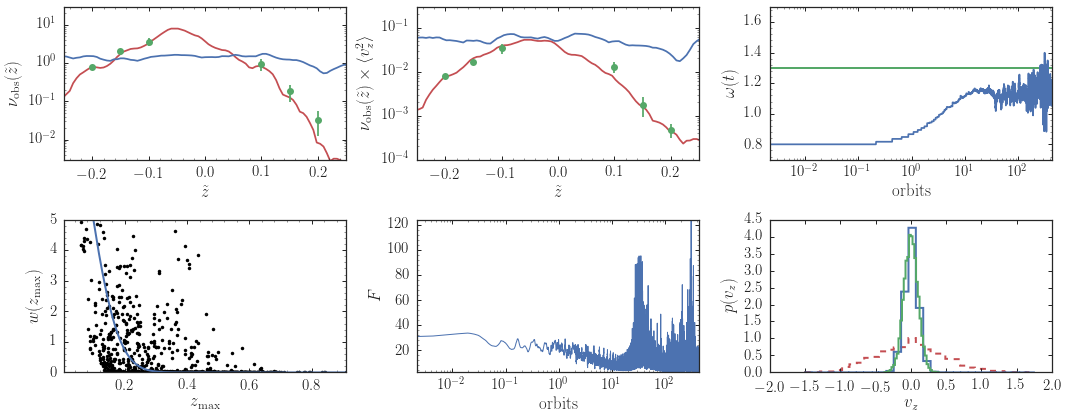

In [33]:
z_out= numpy.linspace(-0.3,0.3,101)
dens_final= compute_dens(z_m2m,zsun_true,z_out,w_out)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
figsize(15,6)
subplot(2,3,1)
bovy_plot.bovy_plot(z_out,dens_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})$',
                   xrange=[-.25,0.25],yrange=[0.003,30.],gcf=True)
bovy_plot.bovy_plot(z_obs,dens_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,dens_final,'-',semilogy=True,overplot=True,zorder=0)
errorbar(z_obs,dens_obs,yerr=dens_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(2,3,2)
densv2_final= compute_densv2(z_m2m,vz_m2m,zsun_true,z_out,w_out)
bovy_plot.bovy_plot(z_out,densv2_init,'-',semilogy=True,
                   xlabel=r'$\tilde{z}$',ylabel=r'$\nu_{\mathrm{obs}}(\tilde{z})\times\langle v_z^2\rangle$',
                   xrange=[-.25,0.25],yrange=[0.0001,.3],gcf=True)
bovy_plot.bovy_plot(z_obs,densv2_obs,'o',semilogy=True,overplot=True)
bovy_plot.bovy_plot(z_out,densv2_final,'-',semilogy=True,overplot=True,zorder=0)
errorbar(z_obs,densv2_obs,yerr=densv2_obs_noise,marker='None',ls='none',color=sns.color_palette()[1])
yscale('log',nonposy='clip')
subplot(2,3,3)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*numpy.mean(omega_true)/2./numpy.pi,omega_out,'-',
                   xlabel=r'$\mathrm{orbits}$',ylabel=r'$\omega(t)$',gcf=True,semilogx=True,zorder=1,
                   yrange=[omega_m2m/1.3,numpy.amax(omega_out)*1.2])
axhline(omega_true,color=sns.color_palette()[1],lw=2.,zorder=0)
ylim(0.7,1.7)
subplot(2,3,4)
bovy_plot.bovy_plot(A_m2m_omega,w_out,'k.',xlabel=r'$z_{\mathrm{max}}$',ylabel=r'$w(z_{\mathrm{max}})$',
                   yrange=[0.,5.],gcf=True)
sindx= numpy.argsort(A_m2m_omega)
w_expect= numpy.exp((A_m2m_omega[sindx]*omega_true)**2./2.*(1./sigma_init**2.-1./sigma_true**2.))
w_expect/= numpy.sum(w_expect)/len(w_expect)
plot(A_m2m_omega[sindx],w_expect,lw=2.)
subplot(2,3,5)
bovy_plot.bovy_plot(numpy.linspace(0.,1.,nstep)*nstep*step*omega_true/2./numpy.pi,numpy.sum(Q,axis=1),lw=1.,
                   semilogx=True,xlabel=r'$\mathrm{orbits}$',ylabel=r'$F$',gcf=True)
subplot(2,3,6)
_= hist(vz_m2m,weights=w_out,histtype='step',lw=2.,normed=True,bins=31,zorder=1)
_= hist(vz_mock,histtype='step',lw=2.,normed=True,bins=31,zorder=2)
_= hist(vz_m2m,histtype='step',lw=2.,normed=True,bins=31,ls='--',zorder=0)
xlabel(r'$v_z$')
ylabel(r'$p(v_z)$')
print("Velocity dispersions: mock, fit",numpy.std(vz_mock),\
      numpy.sqrt(numpy.sum(w_out*(vz_m2m-numpy.sum(w_out*vz_m2m)/numpy.sum(w_out))**2.)/numpy.sum(w_out)))
tight_layout()
print("omega: fit, starting point",numpy.median(omega_out[-1000:-1]),omega_m2m)

Let's compare this to doing the basic M2M fit for different values of $\omega$

In [34]:
omegas= numpy.linspace(1.1,1.5,11)
step= numpy.pi/3.*10.**-2.
nstep= 30000
eps= 10.**-4.
eps_vel= eps/1.
mu= 10.
h_m2m= 0.025
nodens= False
zsun_m2m= zsun_true
Qs= numpy.zeros_like(omegas)
for ii,omega_m2m in enumerate(omegas):
    w_out,Q= run_m2m_weights_wv2(w_init,A_m2m,phi_m2m,omega_m2m,zsun_m2m,
                                 z_obs,dens_obs,dens_obs_noise,densv2_obs,densv2_obs_noise,
                                 nstep=nstep,step=step,mu=mu,eps=eps,eps_vel=eps_vel,
                                 h_m2m=h_m2m,nodens=nodens)
    Qs[ii]= numpy.sum(numpy.median(Q[-100:-1],axis=0))

(-0.3, 8.0)

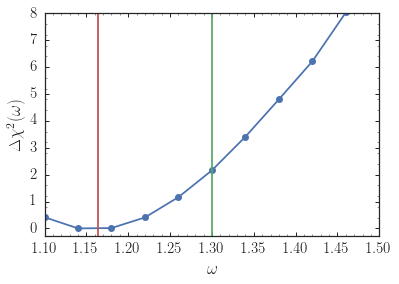

In [35]:
figsize(6,4)
bovy_plot.bovy_plot(omegas,Qs-numpy.amin(Qs),'o-',semilogy=False,
                   xlabel=r'$\omega$',ylabel=r'$\Delta\chi^2(\omega)$')
axvline(omega_true,color=sns.color_palette()[1])
axvline(numpy.median(omega_out[-1000:-1]),color=sns.color_palette()[2])
ylim(-0.3,8.)

What's the answer when we fit a simple DF?

In [36]:
def lnL_df(p,z_obs,dens_obs,dens_obs_noise,densv2_obs,densv2_obs_noise):
    """p=[omega,sigma]"""
    return -0.5*numpy.sum((numpy.exp(-0.5*(z_obs+zsun_true)**2.*p[0]**2./p[1]**2.)*p[0]/p[1]/numpy.sqrt(2.*numpy.pi)
                                       -dens_obs)**2./dens_obs_noise**2.
                          +(numpy.exp(-0.5*(z_obs+zsun_true)**2.*p[0]**2./p[1]**2.)/numpy.sqrt(2.*numpy.pi)*p[0]*p[1]
                                        -densv2_obs)**2./densv2_obs_noise**2.)
sigmas= numpy.linspace(0.05,0.12,101)
omegas= numpy.linspace(0.8,1.5,101)
lnL= numpy.zeros((len(omegas),len(sigmas)))
for ii,omega in enumerate(omegas):
    for jj,sigma in enumerate(sigmas):
        lnL[ii,jj]= lnL_df([omega,sigma],z_obs,dens_obs,dens_obs_noise,densv2_obs,densv2_obs_noise)

Best fit: (omega,sigma) = (1.157,0.093)


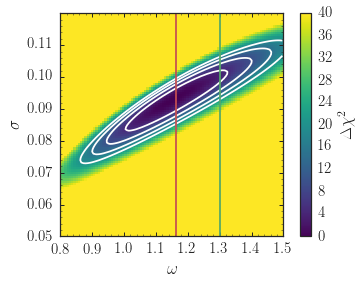

In [37]:
figsize(6,4)
bovy_plot.bovy_dens2d(-2.*(lnL-numpy.amax(lnL)).T,origin='lower',
                      xrange=[omegas[0],omegas[-1]],
                      yrange=[sigmas[0],sigmas[-1]],
                      xlabel=r'$\omega$',ylabel=r'$\sigma$',
                      zlabel=r'$\Delta\chi^2$',
                      colorbar=True,cmap='viridis',vmax=40.,
                      contours=True,levels=numpy.arange(5)*5.,cntrcolors='w',
                      interpolation='nearest')
axvline(omega_true,color=sns.color_palette()[1])
axvline(numpy.median(omega_out[-1000:-1]),color=sns.color_palette()[2])
print("Best fit: (omega,sigma) = (%.3f,%.3f)"\
          %(omegas[numpy.unravel_index(numpy.argmax(lnL),(len(omegas),len(sigmas)))[0]],
            sigmas[numpy.unravel_index(numpy.argmax(lnL),(len(omegas),len(sigmas)))[1]]))

Thus, the M2M optimization finds the correct value.